# Lista de Exercícios 2: Métodos baseados em Diferenças Temporais

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido **antes** de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps2.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 29/04/2025. **Submissões fora do prazo terão uma penalização de -20% da nota final por dia de atraso.**
- ***SUBMISSÕES QUE NÃO SEGUIREM ESTAS INSTRUÇÕES NÃO SERÃO AVALIADAS.***
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Cliff Walking

Cliff Walking é um ambiente representado por um grid de tamanho $4 \times 12$, no qual um agente precisa atravessar o mapa do canto inferior esquerdo até o canto inferior direito, evitando um perigoso penhasco na parte inferior do mapa. O mapa do Cliff Walking pode ser visto no gif abaixo.

![Cliff Walking](https://gymnasium.farama.org/_images/cliff_walking.gif)

O agente sempre inicia na posição $(3, 0)$ e seu objetivo é alcançar a posição $(3, 11)$. As células das três primeiras linhas do grid (linhas $0$, $1$ e $2$) são seguras e o agente pode se mover livremente por elas. Já a linha $3$ contém um penhasco: todas as posições de $(3, 1)$ a $(3, 10)$ representam zonas de risco. Se o agente entrar em uma dessas células, ele cai do penhasco, o que encerra imediatamente o episódio com uma penalidade significativa. A cada passo, o agente recebe uma observação indicando sua posição atual (representada por um valor inteiro) e tem a possibilidade de escolher entre quatro ações possíveis: mover-se para cima, para baixo, para a esquerda ou para a direita. Cada movimento acarreta uma penalidade de $-1$, com exceção das quedas no penhasco, que resultam em uma penalidade severa de $-100$. Um episódio termina quando o agente alcança o objetivo final ou cai do penhasco. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/toy_text/cliff_walking/).

Nesta lista de exercícios, você irá trabalhar com o ambiente Cliff Walking descrito acima. Seu objetivo será implementar e analisar dois algoritmos baseados em diferenças temporais: Sarsa e Q-Learning.

---

## Sarsa

Sua primeira tarefa consiste em implementar um agente baseado no algoritmo Sarsa, que deverá seguir uma política $\varepsilon$-greedy. Para isso, utilize como referência o livro-texto da disciplina e os materiais discutidos em sala.

Você deverá concluir a implementação da classe `SarsaAgent` conforme as instruções abaixo:

1. Implemente o método `__init__` que inicializa um novo agente Sarsa. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$.
2. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
3. Implemente o método `learn`, que atualiza os *Q-values* do agente com base na experiência obtida durante a interação com o ambiente.
4. Implemente o método `train`, que executa o loop de treinamento do algoritmo Sarsa. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar dois elementos: (1) uma tabela contendo os *Q-values* calculados durante o treinamento; e (2) uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [70]:
import sys
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [71]:
class SarsaAgent:
    def __init__(self, observation_space, action_space, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_space = action_space
        self.q_table = np.zeros((observation_space.n, action_space.n))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, next_action):
        td_target = reward + self.gamma * self.q_table[next_state, next_action]
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * td_error

    def train(self, env, episodes):
        rewards = []
        for episode in range(episodes):
            state, _ = env.reset()
            action = self.choose_action(state)
            total_reward = 0

            while True:
                next_state, reward, done, _, _ = env.step(action)
                total_reward += reward
                next_action = self.choose_action(next_state)

                self.learn(state, action, reward, next_state, next_action)

                state, action = next_state, next_action

                if done:
                    break

            rewards.append(total_reward)

        return self.q_table, rewards

4. Agora, treine um novo agente Sarsa no ambiente Cliff Walking por 1000 episódios utilizando os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.9$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene a saída do método `train` nas variáveis `sarsa_q_table` e `sarsa_returns`.

In [72]:
env = gym.make("CliffWalking-v0")

sarsa_agent = SarsaAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.1
)

sarsa_q_table, sarsa_returns = sarsa_agent.train(env, 1_000)

env.close()

In [73]:
# Não altere ou remova esta célula

Nas células a seguir, analise com atenção a política gulosa obtida a partir do treinamento com o algoritmo Sarsa. Na última parte desta lista, você deverá responder algumas perguntas relacionadas a essa política.

In [74]:
def print_greedy_policy(q_table):

    action_map = ['↑', '→', '↓', '←']
    q_table = np.array(q_table)

    if q_table.shape != (48, 4):
        raise ValueError("Q-table must have shape (48, 4)")

    for row in range(4):
        line = []
        for col in range(12):
            state = row * 12 + col
            if row == 3:
                char = (
                    action_map[np.argmax(q_table[state])] if col == 0 else
                    '◎' if col == 11 else
                    '▢'
                )
            else:
                char = action_map[np.argmax(q_table[state])]
            line.append(char)
        print(' '.join(line))

In [75]:
print_greedy_policy(sarsa_q_table)

→ → → → → → → ↓ → ↓ → ↓
↑ → ↑ ↑ → → → → → → → ↓
↑ ↑ ← ↑ ↑ ↑ ↑ → → → → ↓
↑ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ◎


---

## Q-Learning

Nesta atividade, você deverá implementar um agente baseado no algoritmo Q-learning, que também utiliza uma política $\varepsilon$-greedy para explorar o ambiente durante o treinamento. Novamente, utilize o livro-texto da disciplina e os materiais discutidos em sala de aula como referência.

Você deverá concluir a implementação da classe QLearningAgent, conforme as instruções a seguir:

5. Implemente o método `__init__` que inicializa um novo agente Q-Learning. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$.
6. Implemente a função `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
7. Implemente a função `learn`, que atualiza os *Q-values* do agente com base na experiência obtida durante a interação com o ambiente.
8. Implemente o método `train`, que executa o loop de treinamento do algoritmo Q-Learning. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar dois elementos: (1) uma tabela contendo os *Q-values* calculados durante o treinamento; e (2) uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [76]:
class QLearningAgent:
    def __init__(self, observation_space, action_space, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_space = action_space
        self.q_table = np.zeros((observation_space.n, action_space.n))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        td_target = reward + self.gamma * np.max(self.q_table[next_state])
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * td_error

    def train(self, env, episodes):
        rewards = []
        for episode in range(episodes):
            state, _ = env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done, _, _ = env.step(action)
                total_reward += reward

                self.learn(state, action, reward, next_state)

                state = next_state

                if done:
                    break

            rewards.append(total_reward)

        return self.q_table, rewards

9. Treine este novo agente por 1000 episódios no ambiente Cliff Walking. Utilize os mesmos parâmetros do exercício 4. Armazene a saída do método `train` nas variáveis `ql_q_table` e `ql_returns`.

In [77]:
env = gym.make("CliffWalking-v0")

q_learning_agent = QLearningAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.1
)

ql_q_table, ql_returns = q_learning_agent.train(env, 1_000)

env.close()

In [78]:
# Não altere ou remova esta célula

Analise com atenção a política gulosa obtida a partir do treinamento com o algoritmo Q-Learning. Na próxima parte desta lista, você deverá responder algumas perguntas relacionadas a essa política.


In [79]:
print_greedy_policy(ql_q_table)

↓ ← → → → → → ← → → → ↓
→ ← ↑ ↓ → → → → → → ↓ ↓
→ → → → → → → → → → → ↓
↑ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ◎


---

## Análise

10. As políticas obtidas pelos agentes Sarsa e Q-learning apresentam diferenças significativas? Explique por que essas diferenças ocorrem - ou por que não ocorrem.

As políticas obtidas pelos agentes implementados apresentam diferenças significativas. Isso ocorre porque Sarsa e Q-learning utilizam abordagens diferentes para atualizar os Q-values. O primeiro é on-policy e, portanto, busca otimizar a política que está sendo seguida, fazendo com que o caminho mais seguro seja priorizado, já que a política é impactada pelo risco da diversificação ao cair do precipício. O segundo, por outro lado, é off-policy e busca a política que resulta no caminho ótimo, escolhendo sempre a ação que maximiza o Q-value, ignorando o risco.

11. Utilize a biblioteca *matplotlib* para construir um gráfico comparativo dos retornos episódicos obtidos pelos algoritmos Sarsa e Q-Learning. Utilize as variáveis `sarsa_returns` e `ql_returns` obtidas nos exercícios anteriores. No eixo X, represente os episódios; no eixo Y, o retorno acumulado por episódio. Lembre-se de incluir título e legendas apropriadas para facilitar a interpretação dos dados.

**Importante:** O gráfico gerado deve se assemelhar ao exemplo abaixo. Embora os resultados dificilmente sejam idênticos, é fundamental que as tendências de cada algoritmo estejam bem evidentes. Caso os dados estejam muito ruidosos e dificultem a visualização das tendências, experimente aplicar uma média móvel ou um filtro gaussiano para suavizar as curvas.

![Sarsa vs Q-Learning](sarsa-vs-qlearn.png)

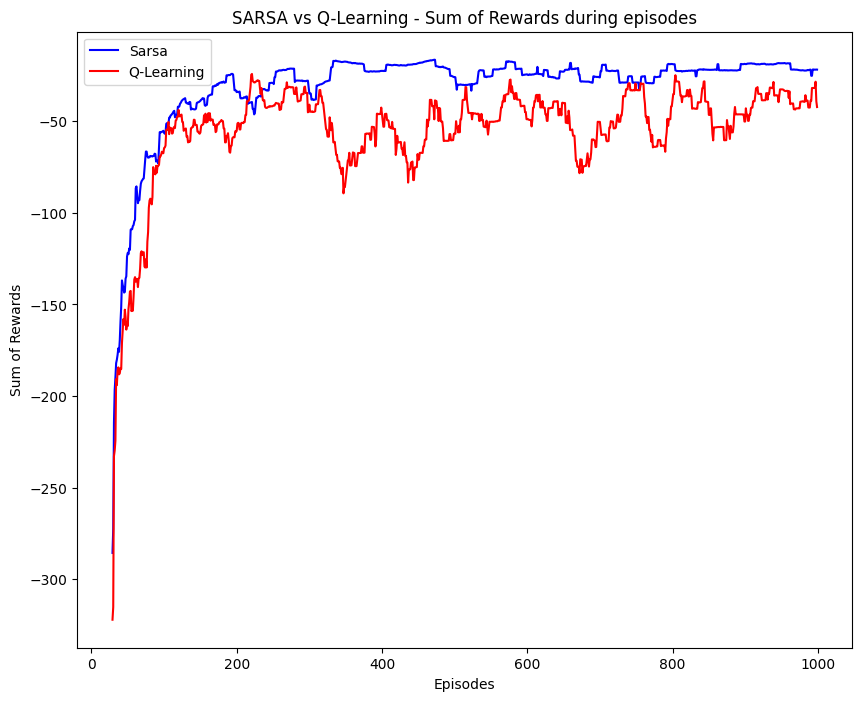

In [80]:
window_size = 30
moving_avg_sarsa = np.convolve(sarsa_returns, np.ones(window_size)/window_size, mode='valid')
moving_avg_q_learning = np.convolve(ql_returns, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 8))

plt.plot(range(window_size - 1, len(sarsa_returns)), moving_avg_sarsa, label="Sarsa", color='blue')
plt.plot(range(window_size - 1, len(ql_returns)), moving_avg_q_learning, label="Q-Learning", color='red')

plt.xlabel('Episodes')
plt.ylabel('Sum of Rewards')
plt.title('SARSA vs Q-Learning - Sum of Rewards during episodes')
plt.legend()
plt.show()

12. Realize um novo treinamento do agente SARSA, desta vez utilizando $\varepsilon = 0$, ou seja, adotando uma política puramente gulosa. Preserve todos os outros parâmetros utilizados anteriormente e armazene a saída do método `train` nas variáveis `sarsa_q_table` e `sarsa_returns`. Ao final do treinamento, observe a política aprendida.

In [83]:
env = gym.make("CliffWalking-v0")

sarsa_agent_epsilon_0 = SarsaAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    alpha=0.1,
    gamma=0.9,
    epsilon=0
)
sarsa_q_table, sarsa_returns = sarsa_agent_epsilon_0.train(env, 1_000)

env.close()

print_greedy_policy(sarsa_q_table)

→ ← → → ↑ ← → → → → ← ↓
↓ ↑ ↑ → → ↓ ↑ → → → ↓ ↓
→ → → → → → → → → → → ↓
↑ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ◎


In [82]:
# Não altere ou remova esta célula

13. Neste caso onde o valor do parâmetro de exploração $\varepsilon$ é igual a zero, o algoritmo Sarsa se torna equivalente ao algoritmo Q-learning? Justifique sua resposta.

Embora os resultados sejam similares quando o algoritmo Sarsa é treinado com $\varepsilon = 0$, ele não se torna equivalente ao Q-learning. Isso ocorre porque o Sarsa ainda é on-policy e, portanto, a política que ele aprende é influenciada pelas ações que ele realmente executa. O  Sarsa realiza a ação gulosa e então atualiza os Q-values com base
no resultado obtido.

O Q-learning, por outro lado, é off-policy e busca otimizar a política que maximiza os Q-values. Ele atualiza os Q-values com base na ação que maximiza o valor esperado antes de executá-la propriamente. A ação é escolhida somente após essa atualização dos Q-values.
Pode-se dizer que o Q-learning aprende com base na melhor ação possível, mesmo que ela não tenha sido tomada.